In [5]:
## First Part: Load the data: 
import pandas as pd 
import numpy as np

def shuffle(x_,y_):
    s = np.arange(x_.shape[0])
    s = np.random.shuffle(s)

    x_re = x_[s]
    y_re = y_[s]

    x_re = np.reshape(x_re,(len(x_),48,48))
    y_re = np.reshape(y_re,(len(y_)))
    return x_re,y_re

def read_fer(path):
    # train_path = "C:\\Users\\Jiaming Nie\\Documents\\Work-DeepGlint\Facial\datasets\\train.csv"
    data = pd.read_csv(path, dtype='a')
    label = np.array(data['emotion'])
    img_data = np.array(data['pixels'])

    N_sample = label.size

    x_data = np.zeros((N_sample, 48 * 48))
    # train_label = np.zeros((N_sample, 7), dtype=int)
    y_label = np.zeros(N_sample, dtype=int)
    # print(train_label)

    for i in range(N_sample):
        x = img_data[i]
        x = np.fromstring(x, dtype=float, sep=' ')
        x_max = x.max()
        x = x / (x_max + 0.0001)
        # print x_max
        # print x
        x_data[i] = x
        y_label[i] = int(label[i])
        # train_label[i, label[i]] = 1 #This step seems direct one-hot encoding
        # print(y_label[i])
        #    img_x = np.reshape(x, (48, 48))
        #    plt.subplot(10,10,i+1)
        #    plt.axis('off')
        #    plt.imshow(img_x, plt.cm.gray)

    x_data = np.reshape(x_data,(len(x_data),48,48))
    return x_data, y_label

def ReadData_fer():
    # ubuntu path
    #path_train = "/home/jiaming/code/DeepGlint-Work/Facial/datasets/train.csv"
    #path_test = "/home/jiaming/code/DeepGlint-Work/Facial/datasets/test.csv"

    # windows path
    path_train = "/train/trainset/1/train.csv"
    path_test = "/train/trainset/1/test.csv"
    path_vali = "/train/trainset/1/val.csv"
    
    x_train, y_train = read_fer(path_train)
    x_test, y_test = read_fer(path_test)
    x_vali, y_vali = read_fer(path_vali)

    x_train, y_train = shuffle(x_train, y_train)
    x_test, y_test = shuffle(x_test, y_test)
    x_vali, y_vali = shuffle(x_vali, y_vali)

    return x_train,y_train,x_test,y_test,x_vali,y_vali

def zca_whitening(X):
    """
        Function to compute ZCA whitening matrix (aka Mahalanobis whitening).
        INPUT:  X: [M x N] matrix.
            Rows: Variables
            Columns: Observations
        OUTPUT: ZCAMatrix: [M x M] matrix
        """
    mean_ = np.mean(X)
    X = X - mean_
    # Covariance matrix [column-wise variables]: Sigma = (X-mu)' * (X-mu) / N
    sigma = np.cov(X, rowvar=True)  # [M x M]
    # Singular Value Decomposition. X = U * np.diag(S) * V
    U, S, V = np.linalg.svd(sigma)
    # U: [M x M] eigenvectors of sigma.
    # S: [M x 1] eigenvalues of sigma.
    # V: [M x M] transpose of U
    # Whitening constant: prevents division by zero
    epsilon = 0.1
    # ZCA Whitening matrix: U * Lambda * U'
    ZCAMatrix = np.dot(U, np.dot(np.diag(1.0 / np.sqrt(S + epsilon)), U.T))  # [M x M]
    return ZCAMatrix

def normalization(x_):

    length = len(x_)

    for i in range(length):
        x_[i] = zca_whitening(x_[i])

    return x_


In [6]:
x_train,y_train,x_test,y_test,x_vali,y_vali = ReadData_fer()

# Normalization
#x_train = normalization(x_train)
#x_test = normalization(x_test)
#x_vali = normalization(x_vali)

x_train = x_train.reshape((len(x_train), 48, 48, 1))
x_test = x_test.reshape((len(x_test), 48, 48, 1))
x_vali = x_vali.reshape((len(x_vali),48,48,1))

print(x_train.shape)
print(x_test.shape)

(28709, 48, 48, 1)
(3589, 48, 48, 1)


In [7]:
# coding=utf-8, keras model implementation 

from __future__ import division

import six
from keras.models import Model
from keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten
)
from keras.layers.convolutional import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D
)
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2

import tensorflow as tf  
import keras.backend.tensorflow_backend as KTF  
KTF.set_session(tf.Session(config=tf.ConfigProto(device_count={'gpu':0})))  

# import tensorflow as tf
# gpu_options = tf.GPUOptions(allow_growth=True)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

# # 設定 Keras 使用的 Session
# tf.keras.backend.set_session(sess)

# #THEANO_FLAGS=device=gpu, floatX=32

In [8]:

def _bn_relu(input):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu block
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "glorot_uniform")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-5))

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv block.
    This is an improved scheme proposed in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "glorot_uniform")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-5))

    def f(input):
        activation = _bn_relu(input)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f


def _shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([shortcut, residual])


def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    """Builds a residual block with repeating bottleneck blocks.
    """
    def f(input):
        for i in range(repetitions):
            init_strides = (1, 1)
            if i == 0 and not is_first_layer:
                init_strides = (2, 2)
            input = block_function(filters=filters, init_strides=init_strides,
                                   is_first_block_of_first_layer=(is_first_layer and i == 0))(input)
        return input

    return f


def basic_block(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=init_strides,
                           padding="same",
                           kernel_regularizer=l2(1e-5))(input)
        else:
            conv1 = _bn_relu_conv(filters=filters, kernel_size=(3, 3),
                                  strides=init_strides)(input)

        residual = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
        return _shortcut(input, residual)

    return f


def bottleneck(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv2D(filters=filters, kernel_size=(1, 1),
                              strides=init_strides,
                              padding="same",
                              kernel_initializer="glorot_uniform",
                              kernel_regularizer=l2(1e-5))(input)
        else:
            conv_1_1 = _bn_relu_conv(filters=filters, kernel_size=(1, 1),
                                     strides=init_strides)(input)

        conv_3_3 = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv_1_1)
        residual = _bn_relu_conv(filters=filters * 4, kernel_size=(1, 1))(conv_3_3)
        return _shortcut(input, residual)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.image_dim_ordering() == 'tf':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


class ResnetBuilder(object):
    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions):
        """Builds a custom ResNet like architecture.
        Args:
            input_shape: The input shape in the form (nb_channels, nb_rows, nb_cols)
            num_outputs: The number of outputs at final softmax layer
            block_fn: The block function to use. This is either `basic_block` or `bottleneck`.
                The original paper used basic_block for layers < 50
            repetitions: Number of repetitions of various block units.
                At each block unit, the number of filters are doubled and the input size is halved
        Returns:
            The keras `Model`.
        """
        _handle_dim_ordering()
        if len(input_shape) != 3:
            raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

        # Permute dimension order if necessary
        if K.image_dim_ordering() == 'tf':
            input_shape = (input_shape[1], input_shape[2], input_shape[0])

        # Load function from str if needed.
        block_fn = _get_block(block_fn)

        input = Input(shape=input_shape)
        conv1 = _conv_bn_relu(filters=64, kernel_size=(7, 7), strides=(2, 2))(input)
        pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)

        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block(block_fn, filters=filters, repetitions=r, is_first_layer=(i == 0))(block)
            filters *= 2

        # Last activation
        block = _bn_relu(block)

        # Classifier block
        block_shape = K.int_shape(block)
        pool2 = AveragePooling2D(pool_size=(block_shape[ROW_AXIS], block_shape[COL_AXIS]),
                                 strides=(1, 1))(block)
        flatten1 = Flatten()(pool2)
        dense = Dense(units=num_outputs, kernel_initializer="he_normal",
                      activation="softmax")(flatten1)

        model = Model(inputs=input, outputs=dense)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [2, 2, 2, 2])

    @staticmethod
    def build_resnet_34(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_50(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_101(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 23, 3])

    @staticmethod
    def build_resnet_152(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 8, 36, 3])


from keras import backend as K
import numpy as np
from keras.utils import to_categorical
import time
import matplotlib.pyplot as plt
from keras.metrics import top_k_categorical_accuracy
from keras.optimizers import *


DIM_ORDERING = {'th', 'tf'}


def _test_model_compile(model):
    for ordering in DIM_ORDERING:
        K.set_image_dim_ordering(ordering)
        model.compile(loss="categorical_crossentropy", optimizer="sgd")
        assert True, "Failed to compile with '{}' dim ordering".format(ordering)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 48, 48, 1)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 24, 24, 64)    3200        input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 24, 24, 64)    256         conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 24, 24, 64)    0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

('Train loss:', 2.2075868106161591)
('Train accuracy:', 0.015430701173847922)
Train on 28709 samples, validate on 3589 samples
Epoch 1/20
28709/28709 [==============================] - 17s - loss: 2.0157 - acc: 0.3444 - top_k_categorical_accuracy: 0.9189 - val_loss: 3.6284 - val_acc: 0.2162 - val_top_k_categorical_accuracy: 0.9114
Epoch 2/20
28709/28709 [==============================] - 12s - loss: 1.9123 - acc: 0.3946 - top_k_categorical_accuracy: 0.9408 - val_loss: 1.9155 - val_acc: 0.4126 - val_top_k_categorical_accuracy: 0.9401
Epoch 3/20
28709/28709 [==============================] - 12s - loss: 1.8744 - acc: 0.4147 - top_k_categorical_accuracy: 0.9451 - val_loss: 1.8790 - val_acc: 0.4160 - val_top_k_categorical_accuracy: 0.9454
Epoch 4/20
28709/28709 [==============================] - 12s - loss: 1.8534 - acc: 0.4209 - top_k_categorical_accuracy: 0.9480 - val_loss: 1.8702 - val_acc: 0.4154 - val_top_k_categorical_accuracy: 0.9479
Epoch 5/20
28709/28709 [=========================

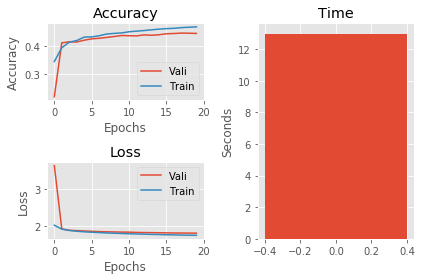

('Test loss:', 1.7850312265920651)
('Test accuracy:', 0.45249373085255012)


In [9]:
def test_resnet18():
    model = ResnetBuilder.build_resnet_18((1, 48, 48), 7)
    #_test_model_compile(model)
    model.summary()
    sgd= SGD(lr=0.1,momentum=0.99, decay=0.9999, nesterov=True)
    model.compile(loss="categorical_crossentropy", optimizer=sgd,metrics=['acc',top_k_categorical_accuracy])
    
    print('--Non Training--')
    score = model.evaluate(x_train, to_categorical(y_train), verbose=0)
    print('Train loss:', score[0])
    print('Train accuracy:', score[1])

    
    batch_size = 128
    EPOCH = 20
    
    results = []
    start_time = time.time()

    history = model.fit(x_train, to_categorical(y_train),
              batch_size=batch_size,
              epochs=EPOCH,
              validation_data=(x_vali, to_categorical(y_vali)))
    
    
    average_time_per_epoch = (time.time() - start_time) / EPOCH
    results.append((history, average_time_per_epoch))
    plt.style.use('ggplot')
    ax1 = plt.subplot2grid((2, 2), (0, 0))
    ax1.set_title('Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epochs')
    ax2 = plt.subplot2grid((2, 2), (1, 0))
    ax2.set_title('Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epochs')
    ax3 = plt.subplot2grid((2, 2), (0, 1), rowspan=2)
    ax3.set_title('Time')
    ax3.set_ylabel('Seconds')

    for result in results:
        ax1.plot(result[0].epoch, result[0].history['val_acc'], label='Vali')
        ax1.plot(result[0].epoch, result[0].history['acc'], label='Train')
        ax2.plot(result[0].epoch, result[0].history['val_loss'], label='Vali')
        ax2.plot(result[0].epoch, result[0].history['loss'], label='Train')

    ax1.legend()
    ax2.legend()
    ax3.bar(np.arange(len(results)), [x[1] for x in results],
            align='center')
    plt.tight_layout()
    plt.show()
    
    score = model.evaluate(x_test, to_categorical(y_test), verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

test_resnet18()
